In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/Users/sijo/Documents/Epidermis map/Scripts'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from EPI_misc_scripts_v1_1 import *
from EPI_affinity_propagation_v1_0 import *
from EPI_neg_binom_regression_v1_1 import *
from EPI_pseudotemporal_ordering_v1_0 import *

# Initialize engines

In [5]:
from ipyparallel import Client

In [6]:
c = Client(profile='default')

In [7]:
dview = c[:]

In [8]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/sijo/Documents/Epidermis map/Scripts")')
dview.execute('from EPI_misc_scripts_v1_1 import *')
dview.execute('from EPI_affinity_propagation_v1_0 import *')
dview.execute('from EPI_neg_binom_regression_v1_1 import *')
dview.execute('from EPI_pseudotemporal_ordering_v1_0 import *')

<AsyncResult: execute>

# Import Data

In [9]:
exp_id = '201512281816'
path_input = '/Users/sijo/Documents/Epidermis map/Data/Input/TD_v1.2'
path_output = '/Users/sijo/Documents/Epidermis map/Data/Output/TD_v1.2'

In [10]:
seq_TD = loadData_v1(path_input, exp_id, 'seq_TD', 'DataFrame')
meta_TD = loadData_v1(path_input, exp_id, 'meta_TD', 'DataFrame')

In [11]:
seq = loadData_v1(path_input, '201509151726', 'seq', 'DataFrame')
meta = loadData_v1(path_input, '201509151726', 'meta', 'DataFrame')

In [12]:
s_groups_1st = loadData_v1(path_input, '201509151726', 's_groups_1st', 'Series')
s_groups_2nd = loadData_v1(path_input, '201509151726', 's_groups_2nd', 'Series')
g_groups_1st = loadData_v1(path_input, '201509151726', 'g_groups_1st', 'Series')

# Unsupervised clustering of all Gli1-Tomato+ cells

### Transform data for clustering and select features

In [13]:
def dropNull_v2(dataset, path, drop_spikes = True, drop_markers = True, cutoff_mean = 0):

    """
    Takes the merged sequencing dataset, drops spike values (based on 'spike.txt' containing all current spike index names) unless 
    set False and removes all unexpressed genes (sum == 0 over the whole dataset)
    ----------
    dataset: seq dataset [pd.DataFrame] containing m cells x n genes.
    path: path where txt. files specifying spikes and repeats are stored.
    drop_spikes: [bool] indicating whether ERCC spikes are removed from the dataset.
    drop_markers: [bool] indicating whether markers are removed from the dataset.
    cutoff_mean: Average expression count [float] at which a gene is dropped from the dataset.
    ----------
    returns seq dataset [pd.DataFrame] containing m cells x n genes.
    """
      
    ###drop spike and repeat indices unless specifically disabled
    
    spikes = open('%s/spikes.txt' % (path),'r').read().split('\n')[:-1]
    markers = open('%s/markers.txt' % (path),'r').read().split('\n')[:-1]
    
    if drop_spikes == True:
        print '\nDropping spikes from dataset'
        dataset = dataset.drop(spikes)
        
    if drop_markers == True:
        print '\nDropping markers from dataset'
        dataset = dataset.drop(markers)   
    
        
    ###drop rows of non-expressed genes
    
    print '\nDropping unexpressed genes from dataset'
    dataset = dataset.drop(dataset[dataset.mean(axis = 1) <= cutoff_mean].index)
    
    return dataset

In [14]:
def select_features_v2(dataset, cutoff_mean, cutoff_corr, nr_features, path_input, percentile=95, return_all=False, drop_spikes = True, drop_markers = True):

    """
    Helper function to compress the feature selection workflow.
    ----------
    dataset: [DataFrame] of m cells x n genes. Must be non-transformed.
    cutoff_mean: gene expression cutoff [float]. Average expression required for a gene to be retained
    in the dataset.
    cutoff_corr: correlation cutoff [int]. Number of highly correlated partner genes required for a gene to be retained
    in the dataset.
    nr_features: number of features to select [int]. Features are ordered according to log2_cv_diff.
    path_input: name of path leading to input files including spike and repeat lists
    percentile: correlation percentile at which two genes are considered highly correlated. Default: 95.
    return_all: if True, additionally returns corr_filt, log2_cv_diff and x_opt. Default: False
    ----------
    return log2-transformed DataFrame of m cells and n selected features. If return_all is True, additionally 
    returns corr_filt, log2_cv_diff and x_opt
    """

    dataset = dropNull_v2(dataset, path_input, drop_spikes = drop_spikes, drop_markers = drop_markers, cutoff_mean=cutoff_mean)
    
    print "\nAfter mean expression cutoff of %s, %s genes remain" % (cutoff_mean, len(dataset.index))
    
    corr_filt = gene_correlation_v1(dataset, method ='pearson', percentile=percentile)
    
    genes_sel_1 = corr_filt[corr_filt >= cutoff_corr].index 
    
    print "\nAfter correlation cutoff of %s, %s genes remain\n" % (cutoff_corr, len(genes_sel_1))
    
    log2_cv_diff, xopt = log2_cv_fit(dataset.ix[genes_sel_1])
    
    genes_sel_2 = log2_cv_diff.order()[-nr_features:].index
    
    draw_log2_cv_diff(dataset.ix[genes_sel_1], log2_cv_diff, xopt, selected=genes_sel_2)
    
    print "\nAfter high variance feature selection, %s genes remain" % (len(genes_sel_2))
    
    dataset = dataset.ix[genes_sel_2]
    
    dataset = log2Transform(dataset)
    
    if return_all==True:
    
        return dataset, corr_filt, log2_cv_diff, xopt
    
    else:
        
        return dataset

In [15]:
def draw_AP_dist_mat(dist_mat, groups, **kwargs):
    
    """
    Draws distance matrices of either m cells or n genes randomly shuffled and
    ordered according to group Series (e.g. AP clustering).
    ----------
    dist_mat: pd.DataFrame with distances of either m x m cells or n x n genes.
    groups: pd.Series with ordered cluster identity of m cells or n genes.
    """
    
    plt.figure(figsize = [20,10], facecolor = 'w')

    ax0 = plt.subplot(121)

    tmp_ix = list(dist_mat.index)
    random.shuffle(tmp_ix)

    ax0.matshow(dist_mat.ix[tmp_ix, tmp_ix], **kwargs)

    ax1 = plt.subplot(122)

    ax1.matshow(dist_mat.ix[groups.index, groups.index], **kwargs)

In [16]:
def get_CLR(corr_mat, method = 'normal'):
    
    """
    Calculates context likelihood of relatedness (Faith et al. 2007).
    ----------
    corr_mat: DataFrame containing the similarity (e.g. Pearson correlation) of n x n genes.
    method: CLR method. 'normal'.
    ----------
    returns DataFrame of CLR-corrected distance of n x n genes.
    """
    
    #get zscores along both axes
           
    Z0 = corr_mat.apply(lambda x: (x - np.mean(x)) / np.std(x), axis = 0)
    Z1 = corr_mat.apply(lambda x: (x - np.mean(x)) / np.std(x), axis = 1)
    
    #combine zscores uing unweighted Stouffer method
        
    Z = (Z0 + Z1) / np.sqrt(2)
    
    return Z

In [17]:
seq_sel_TD = dropNull_v2(seq_TD, path_input, cutoff_mean = 0.05)


Dropping spikes from dataset

Dropping markers from dataset

Dropping unexpressed genes from dataset


In [18]:
len(seq_sel_TD.index)

8524

In [21]:
len(seq_TD.columns)

227

In [18]:
seq_sel_TD = cellCutoff(seq_sel_TD, 2000)


Removing cells with less than 2000 transcripts


In [26]:
Counter(meta_TD.ix['cell_fraction'])

Counter({'Gli1-Tomato+/Sca1+': 106, 'Gli1-Tomato+/Sca1-': 121})

In [19]:
len(seq_sel_TD.columns)

181


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.05, 8502 genes remain

After correlation cutoff of 5, 8502 genes remain

Optimization terminated successfully.

/mnt/kauffman/joosts/projects/STRT_epidermis/scripts/EPI_misc_scripts_v1_1.py:363: FutureWarning: order is deprecated, use sort_values(...)
  corr_filt = corr_mat.apply(lambda x: x >= corr_filt_thresh).sum(axis = 1).order()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: order is deprecated, use sort_values(...)



         Current function value: 1706.355611
         Iterations: 44
         Function evaluations: 83

After high variance feature selection, 2500 genes remain

Calculating binary logarithm of x + 1


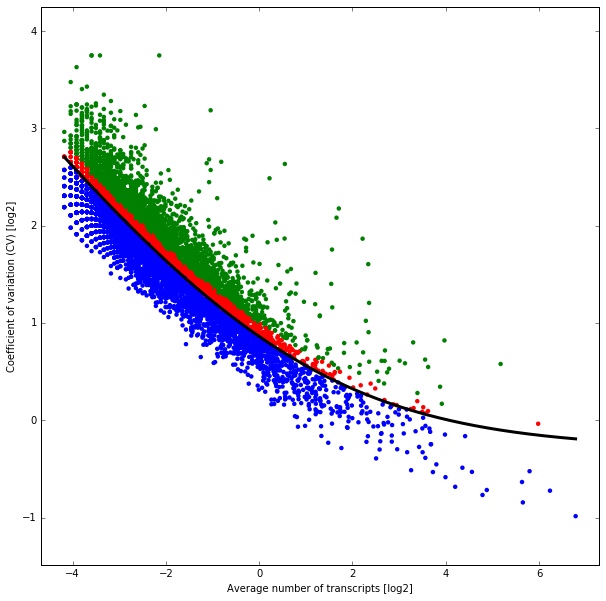

In [20]:
seq_sel_TD = select_features_v2(seq_sel_TD, 0.05, 5, 2500, path_input, percentile=95, return_all=False, drop_spikes = False, drop_markers = False)

### Checkpoint

In [21]:
saveData_v1(seq_sel_TD, path_output, exp_id, 'seq_sel_TD')

In [22]:
seq_sel_TD = loadData_v1(path_output, exp_id, 'seq_sel_TD', 'DataFrame')

### Cluster cells 

In [85]:
affy_s_TD = seq_sel_TD.corr()

         -2.0     -1.9     -1.8     -1.7     -1.6     -1.5     -1.4     -1.3  \
0.50 -160.553 -160.553 -160.553 -160.553 -160.553  -156.53 -156.991  -156.53   
0.55 -160.553 -160.553 -160.553 -160.553 -160.553  -156.53 -156.991  -156.53   
0.60 -160.553 -160.553 -160.553 -160.553 -160.553  -156.53 -156.991 -157.423   
0.65 -160.553 -160.553 -160.553 -160.553 -160.553  -156.53  -156.53  -156.53   
0.70 -160.553 -160.553 -160.553 -160.553  -156.53  -156.53  -156.53  -156.53   
0.75 -160.553 -160.553 -160.553 -160.553  -156.53  -156.53  -156.53  -156.53   
0.80 -160.553 -160.553 -160.553 -160.553  -156.53  -156.53  -156.53  -156.53   
0.85 -160.553 -160.553 -160.553 -160.553 -160.553 -160.553  -156.53  -156.53   
0.90 -160.553 -160.553 -160.553 -160.553 -160.553 -160.553 -160.553 -160.553   
0.95 -160.553 -160.553 -160.553 -160.553 -160.553 -160.553 -160.553 -160.553   

         -1.2     -1.1     -1.0     -0.9     -0.8     -0.7     -0.6     -0.5  \
0.50 -153.477 -153.477  -153.39  -154.4

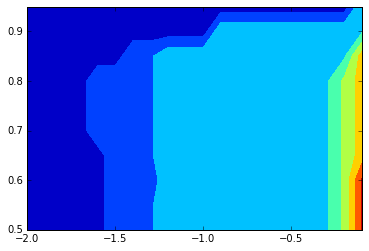

In [86]:
preference = np.arange(-2.0, 0.0, 0.1)
damping = np.arange(0.5, 1.0, 0.05)

IC_s, Ng_s = AP_IC_v3P(seq_sel_TD, affy_s_TD, 0, 'precomputed', preference, damping, path_scripts, dview, linkage='single', criterion='BIC')
print IC_s, Ng_s, plt.contourf(IC_s.columns, IC_s.index, IC_s)

pref_s, damp_s = AP_IC_findmin(IC_s)
print pref_s, damp_s

In [87]:
s_groups_TD = AP_clustering_v3P(seq_sel_TD, affy_s_TD, 0, 'precomputed', -0.2, 0.75, path_scripts, linkage='single')

In [88]:
len(set(s_groups_TD))

5

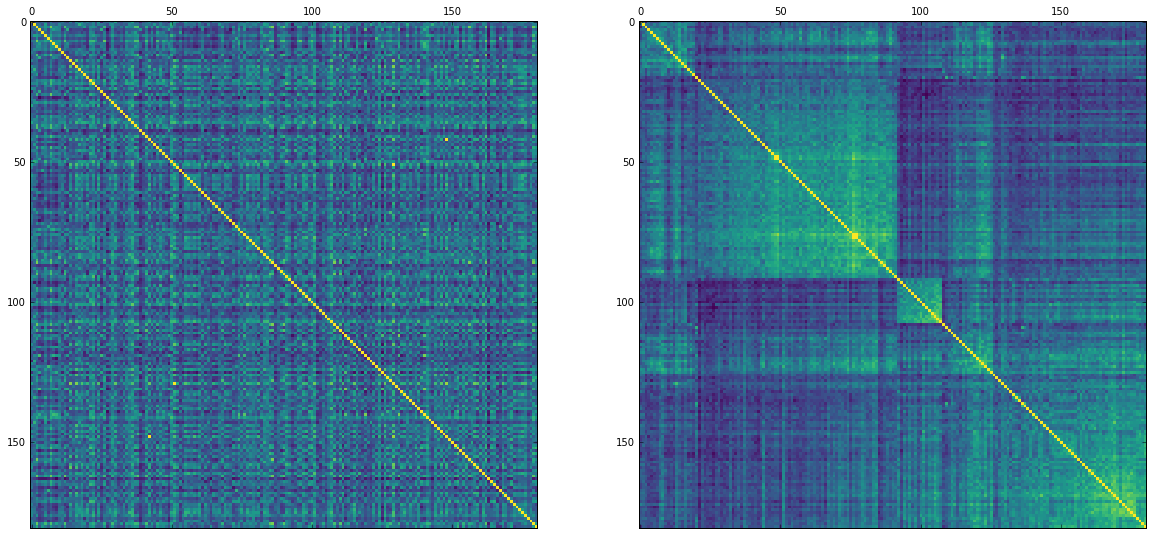

In [90]:
draw_AP_dist_mat(affy_s_TD, s_groups_TD, cmap = plt.cm.viridis, vmin = 0.0, vmax = 0.5)

### Cluster genes

In [91]:
affy_g_TD = seq_sel_TD.T.corr()

         -8.0     -7.9     -7.8     -7.7     -7.6     -7.5     -7.4     -7.3  \
0.75  -2142.2  -2142.2 -2141.87 -2141.87 -2149.52 -2162.89 -2145.98 -2164.01   
0.80 -2159.77 -2156.22 -2156.22 -2156.22 -2154.18 -2156.35 -2169.37 -2169.67   
0.85 -2146.27 -2146.27 -2149.47 -2134.14 -2152.44 -2152.44 -2152.44 -2152.44   
0.90 -2156.22 -2156.22 -2156.22 -2156.22 -2156.22 -2156.22 -2156.22 -2156.22   

         -7.2     -7.1   ...        -5.0     -4.9     -4.8     -4.7     -4.6  \
0.75 -2164.01 -2137.69   ...    -2173.69 -2174.12  -2172.7  -2172.7  -2172.7   
0.80 -2169.67 -2172.94   ...    -2173.69 -2173.35  -2172.7 -2173.35 -2195.05   
0.85 -2152.44 -2140.73   ...     -2172.7  -2172.7 -2183.84 -2183.84 -2183.84   
0.90 -2154.08 -2154.08   ...    -2167.52 -2167.52 -2166.89 -2166.89 -2166.89   

         -4.5     -4.4     -4.3     -4.2     -4.1  
0.75 -2183.84 -2186.18 -2186.18  -2190.4  -2190.4  
0.80 -2183.84 -2191.76 -2191.76 -2191.81 -2188.11  
0.85 -2183.84 -2190.32 -2184.52 -2191.76 -

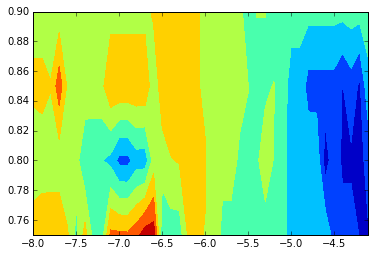

In [92]:
preference = np.arange(-8.0, -4.0, 0.1)
damping = np.arange(0.75, 0.95, 0.05)

IC_g, Ng_g = AP_IC_v3P(seq_sel_TD, affy_g_TD, 1, 'precomputed', preference, damping, path_scripts, dview, linkage='single', criterion='BIC')
print IC_g, Ng_g, plt.contourf(IC_g.columns, IC_g.index, IC_g)

pref_g, damp_g = AP_IC_findmin(IC_g)
print pref_g, damp_g

In [103]:
g_groups_TD = AP_clustering_v3P(seq_sel_TD, affy_g_TD, 1, 'precomputed', -7.0, 0.8, path_scripts, linkage = 'single')

In [98]:
len(set(g_groups_TD))

21

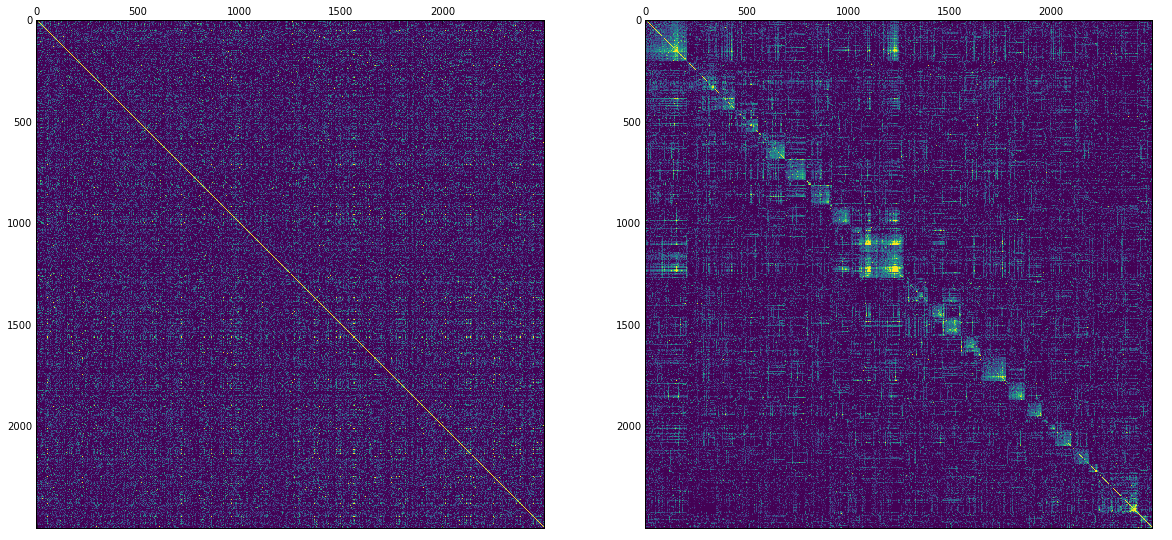

In [99]:
draw_AP_dist_mat(affy_g_TD, g_groups_TD, cmap = plt.cm.viridis, vmin = 0.0, vmax = 0.5)

### Draw heatmap

In [94]:
def draw_heatmap(dataset, cell_groups, gene_groups, cmap = plt.cm.jet):
    
    """
    Draw heatmap showing gene expression ordered according to cell_groups and
    gene_groups Series (e.g. AP clustering). Cell and gene groups membership is 
    visualized in two additional panels:
    ----------
    dataset: pd.DataFrame of m cells * n genes.
    cell_groups: pd.Series with ordered cluster identity of m cells.
    gene_groups: pd.Series with ordered cluster identity of n genes.
    cmap: matplotlib color map. Default: plt.cm.jet.
    """
    
    dataset = dataset.ix[gene_groups.index, cell_groups.index]
    dataset = dataset.apply(lambda x: x / max(x), axis = 1)

    plt.figure(figsize=(20,20), facecolor = 'w')
    
    #draw heatmap

    axSPIN1 = plt.axes()
    axSPIN1.set_position([0.05, 0.05, 0.9, 0.9])
    
    axSPIN1.imshow(dataset, aspect = 'auto', interpolation = 'nearest', cmap = cmap)
    
    remove_ticks(axSPIN1)
    
    #draw genes bar

    divider = make_axes_locatable(axSPIN1)

    axGene_gr = divider.append_axes("right", size= 0.5, pad=0.05)

    axGene_gr.set_xlim(-0.5,0.5)
    axGene_gr.imshow(np.matrix(gene_groups).T, aspect = 'auto')
    
    remove_ticks(axGene_gr)
    
    #draw genes bar ticks
    
    gene_groups_ticks = pd.Series(index = set(gene_groups))
    
    for gr in gene_groups_ticks.index:
                
        first_ix = list(gene_groups.values).index(gr)
        last_ix = len(gene_groups) - list(gene_groups.values)[::-1].index(gr)
        gene_groups_ticks[gr] = first_ix + ((last_ix - first_ix) / 2.0)
        
    axGene_gr.set_yticks(gene_groups_ticks.values)
    axGene_gr.set_yticklabels(gene_groups_ticks.index)
    axGene_gr.yaxis.set_ticks_position('right')
    
    #draw cells bar
    
    axCell_gr = divider.append_axes("bottom", size= 0.5, pad=0.05)

    axCell_gr.set_ylim(-0.5, 0.5)
    axCell_gr.imshow(np.matrix(cell_groups), aspect = 'auto')
    
    remove_ticks(axCell_gr)
    
    #draw cells bar ticks
    
    cell_groups_ticks = pd.Series(index = set(cell_groups))
        
    for gr in cell_groups_ticks.index:
                
        first_ix = list(cell_groups.values).index(gr)
        last_ix = len(cell_groups) - list(cell_groups.values)[::-1].index(gr)
        cell_groups_ticks[gr] = first_ix + ((last_ix - first_ix) / 2.0)
        
    axCell_gr.set_xticks(cell_groups_ticks.values)
    axCell_gr.set_xticklabels(cell_groups_ticks.index)
    axCell_gr.xaxis.set_ticks_position('bottom')

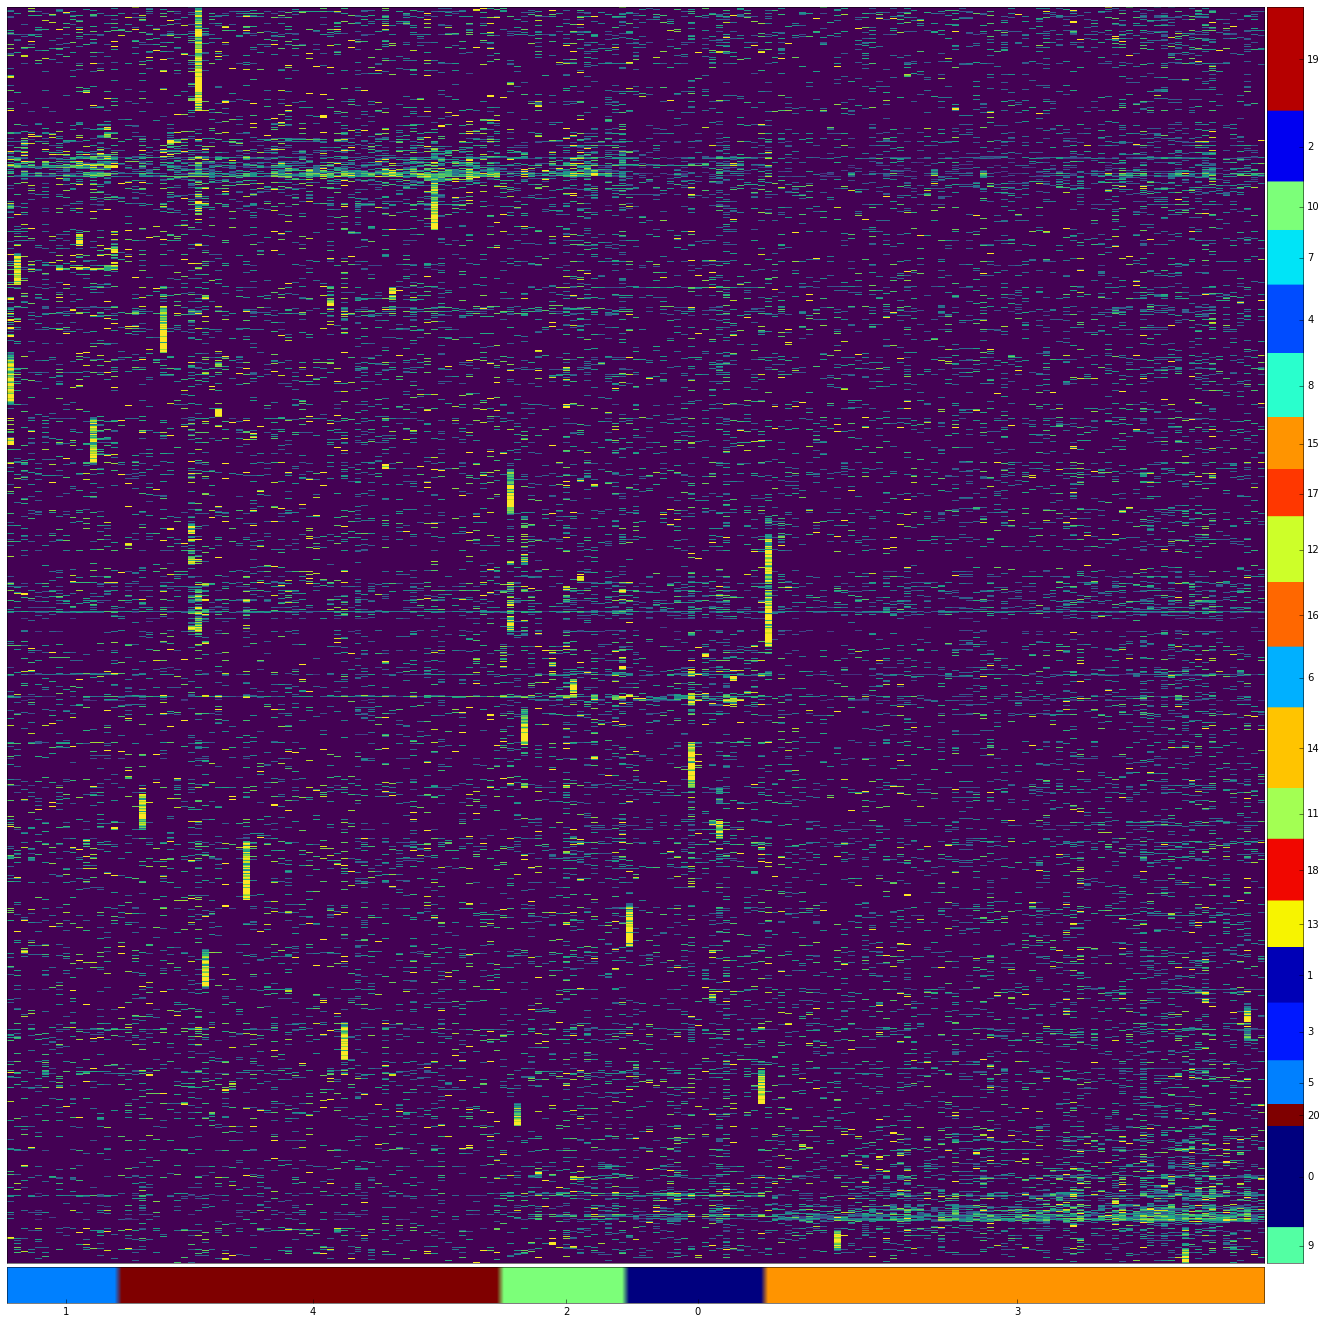

In [104]:
draw_heatmap(seq_sel_TD, s_groups_TD, g_groups_TD, cmap = plt.cm.viridis)

### Reduce and reorder heatmaps

In [105]:
g_groups_TD = g_groups_TD[g_groups_TD.isin([2,7,6,0])]

In [106]:
s_groups_TD = AP_groups_reorder(s_groups_TD, [1,4,2,0,3])

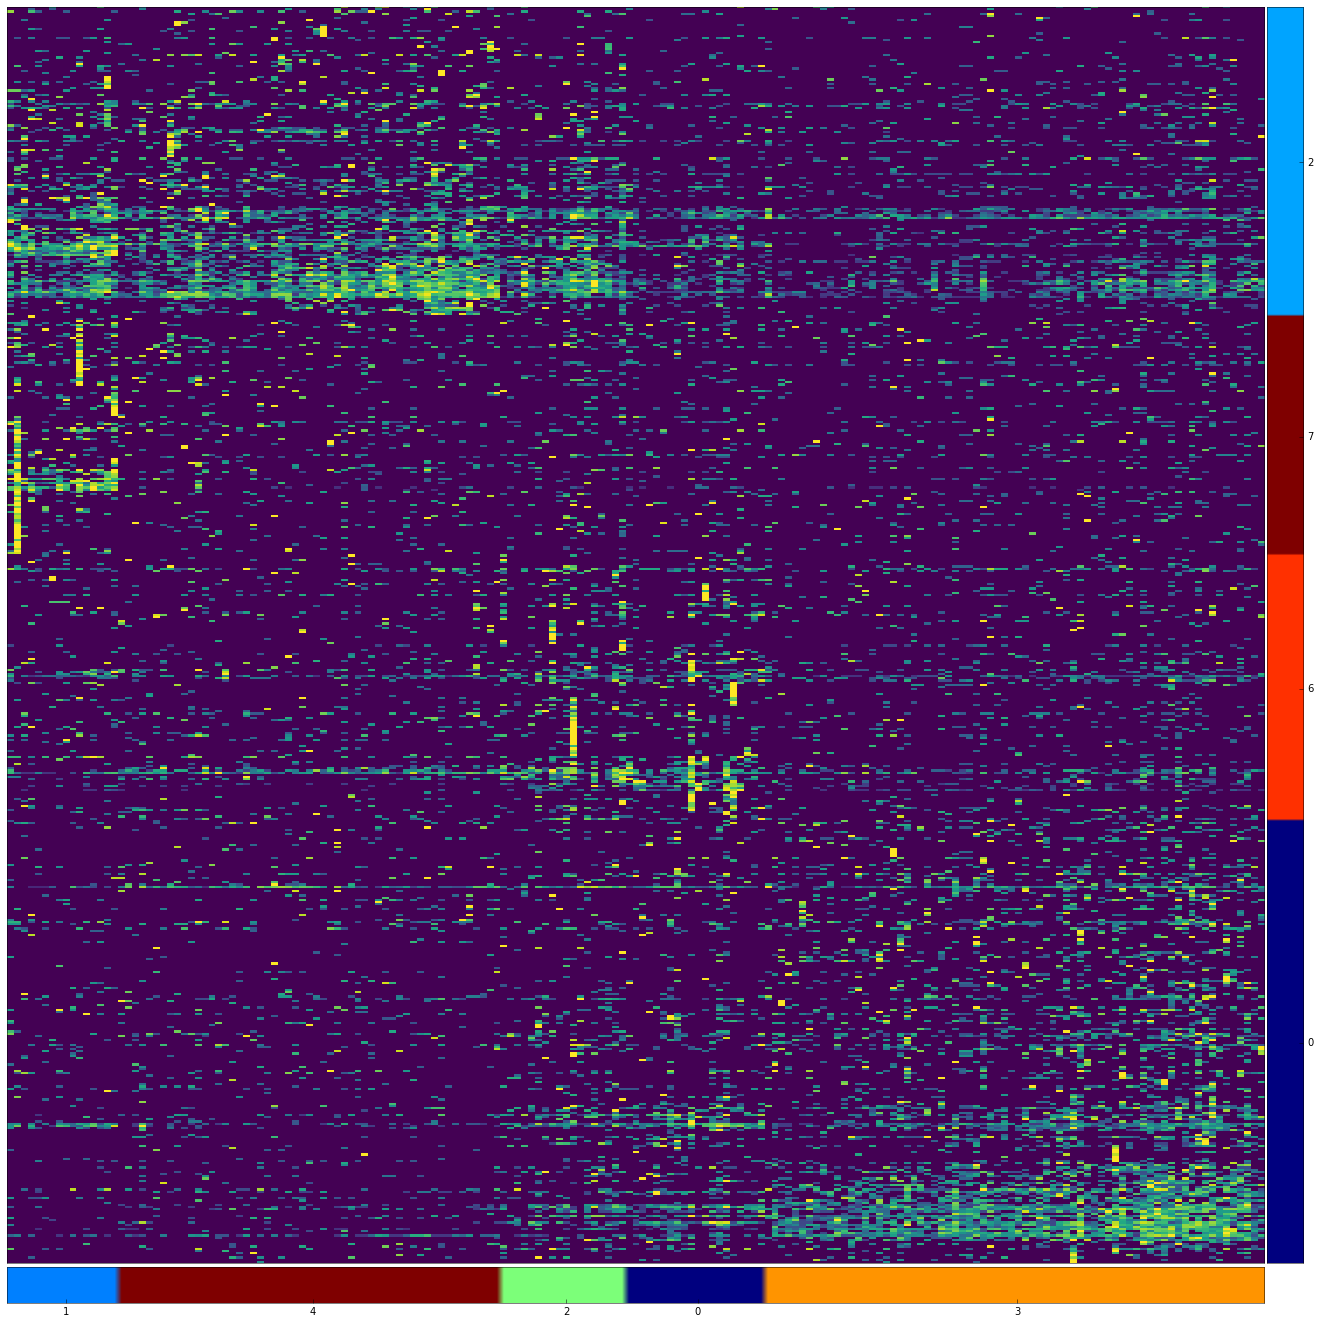

In [107]:
draw_heatmap(seq_sel_TD, s_groups_TD, g_groups_TD, cmap = plt.cm.viridis)

### Checkpoint

In [108]:
#saveData_v1(s_groups_TD, path_output, exp_id, 's_groups_TD')
#saveData_v1(g_groups_TD, path_output, exp_id, 'g_groups_TD')

In [21]:
s_groups_TD = loadData_v1(path_output, exp_id, 's_groups_TD', 'Series')
g_groups_TD = loadData_v1(path_output, exp_id, 'g_groups_TD', 'Series')

# Get tSNE representation of data

In [172]:
def tSNE_get_params(dist_mat, groups, dview, perplexity, early_exaggeration, learning_rate, n_iter, sec_var = 'early_exaggeration', **kwargs):
    
    ##########################################################
    
    def get_tSNE(param, dist_mat):
        
        """
        Helper function for parallelization of tSNE_get_params.
        """
        
        tsne = TSNE(n_components=2, perplexity=param['perplexity'], early_exaggeration=param['early_exaggeration'], 
                    learning_rate=param['learning_rate'], n_iter=param['n_iter'])
        
        return pd.DataFrame(tsne.fit_transform(dist_mat), index = dist_mat.index, columns = ['x', 'y'])
    
    ##########################################################
    
    #get tSNE init dict
    
    param_dict = {}
    
    cs = perplexity
    if sec_var == 'early_exaggeration':
            rs = early_exaggeration
    elif sec_var == 'learning_rate':
            rs = learning_rate
    elif sec_var == 'n_iter':
            rs = n_iter   
            
    for c in cs:
        for r in rs:
            param_dict[c,r] = {}
            param_dict[c,r]['perplexity'] = c
            param_dict[c,r]['early_exaggeration'] = early_exaggeration
            param_dict[c,r]['learning_rate'] = learning_rate
            param_dict[c,r]['n_iter'] = n_iter
            param_dict[c,r][sec_var] = r

    #get tSNE coords in parallel
    
    keys = param_dict.keys()
            
    tsne_coords = dview.map_sync(get_tSNE, 
                                 [param_dict[k] for k in keys], 
                                 [dist_mat for k in keys])
    
    tsne_coords_dict = {}
    for ix, k in enumerate(keys):
        tsne_coords_dict[k] = tsne_coords[ix]
    
    #print data
    
    #initialize figure

    height = 5 * len(rs)
    width = 5 * len(cs)

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #initialize gridspec
    
    gs = plt.GridSpec(nrows = len(rs), ncols = len(cs), wspace=0.00, hspace=0.00)
    
    for pos_c, c in enumerate(cs):
        for pos_r, r in enumerate(rs):
            
            tsne_coords = tsne_coords_dict[c,r]

            #define x- and y-limits

            x_min, x_max = np.min(tsne_coords['x']), np.max(tsne_coords['x'])
            y_min, y_max = np.min(tsne_coords['y']), np.max(tsne_coords['y'])
            x_diff, y_diff = x_max - x_min, y_max - y_min

            pad = 3.0

            if x_diff > y_diff:
                xlim = (x_min - pad, x_max + pad)
                ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

            if x_diff < y_diff:
                xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
                ylim = (y_min - pad, y_max + pad)

            #define x- and y-axes

            ax1 = plt.subplot(gs[pos_r, pos_c])

            ax1.set_xlim(xlim[0], xlim[1])
            ax1.set_ylim(ylim[0], ylim[1])

            remove_ticks(ax1)

            #define colormap

            gr_max = float(np.max(groups.values))
            clist_tsne = [gr / gr_max for gr in groups.values]

            ax1.scatter(tsne_coords.ix[groups.index, 'x'],
                        tsne_coords.ix[groups.index, 'y'], 
                        s = 10,
                        linewidth = 0.0,
                        c = clist_tsne)

            #draw params

            ax1.text(xlim[0] + ((xlim[1] - xlim[0]) * 0.5), 
                    ylim[0] + ((ylim[1] - ylim[0]) * 0.98), 
                     'perplexity = %s, %s = %s' % (c,sec_var,r), 
                     family = 'Liberation Sans', fontsize = 10, ha = 'center', va = 'center')

In [171]:
dist_mat_tsne_TD = dist_mat_dim_reduc(seq_sel_TD, dim=40, method='PCA')

In [1]:
"""
tSNE_get_params(dist_mat_tsne_TD, 
                s_groups_TD, 
                dview, 
                np.arange(10,100,10), 
                2.0, 
                np.arange(0,1000,25),  
                10000, 
                sec_var = 'learning_rate')
"""

"\ntSNE_get_params(dist_mat_tsne_TD, \n                s_groups_TD, \n                dview, \n                np.arange(10,100,10), \n                2.0, \n                np.arange(0,1000,25),  \n                10000, \n                sec_var = 'learning_rate')\n"

In [181]:
#tsne_coords_TD = find_tSNE_v1P(dist_mat_tsne_TD, s_groups_TD, 30, dview, perplexity=20, early_exaggeration=2.0, learning_rate=275.0, 
                                #n_iter=10000, init='random', verbose=0, random_state=None)

In [180]:
tsne_TD = tsne_coords_TD[0]

### Checkpoint

In [182]:
saveData_v1(tsne_TD, path_output, exp_id, 'tsne_TD')

# Fit negative binomial regression model (TD data)

In [155]:
def neg_binom_estimate_prob_v1P(traces, reference, dview, repeats = 100000):
    
    #########################
    
    def neg_binom_estimate_prob_helper_overexpr_v1(traces, gene, reference, repeats = repeats):
    
        #define output

        output = pd.DataFrame(index = [gene], columns = [gr for gr in traces.index if gr != reference])

        #iterate over groups

        for gr in [gr for gr in traces.index if gr != reference]:

            choice1 = np.random.choice(traces.ix[reference], size = repeats, replace = True)
            choice2 = np.random.choice(traces.ix[gr], size = repeats, replace = True)

            output.ix[gene, gr] = 1 - np.sum(choice2 > choice1) / float(repeats)

        return output
    
    #########################
    
    l = len(traces.index)
    
    output_tmp = dview.map_sync(neg_binom_estimate_prob_helper_overexpr_v1,
                                [traces.ix[g] for g in traces.index],
                                [g for g in traces.index],
                                [reference] * l,
                                [repeats] * l)
        
    output = pd.concat(output_tmp)
    
    return output

In [495]:
def neg_binom_estimate_prob_thr_v1P(traces, threshold, dview, repeats = 100000):
    
    #########################
    
    def neg_binom_estimate_prob_helper_overexpr_v1(traces, gene, treshold, repeats = repeats):
    
        #define output

        output = pd.DataFrame(index = [gene], columns = [gr for gr in traces.index])

        #iterate over groups

        for gr in [gr for gr in traces.index]:

            choice1 = threshold
            choice2 = np.random.choice(traces.ix[gr], size = repeats, replace = True)

            output.ix[gene, gr] = 1 - np.sum(choice2 > choice1) / float(repeats)

        return output
    
    #########################
    
    l = len(traces.index)
    
    output_tmp = dview.map_sync(neg_binom_estimate_prob_helper_overexpr_v1,
                                [traces.ix[g] for g in traces.index],
                                [g for g in traces.index],
                                [threshold] * l,
                                [repeats] * l)
        
    output = pd.concat(output_tmp)
    
    return output

In [183]:
def neg_binom_get_binarized(pval, cutoff):
    
    output = pd.DataFrame(index = pval.index, columns = pval.columns).fillna(0)  
    output[pval<cutoff] = True
    
    return output

In [184]:
def neg_binom_get_distances(summary, binarized, reference):
    
    output = {}
    
    output_mean = pd.DataFrame(index = binarized.index, columns = binarized.columns).fillna(0)
    output_median = pd.DataFrame(index = binarized.index, columns = binarized.columns).fillna(0)
    output_P5 = pd.DataFrame(index = binarized.index, columns = binarized.columns).fillna(0)
    output_P25 = pd.DataFrame(index = binarized.index, columns = binarized.columns).fillna(0)
    
    for gr in binarized.columns:
        g_sel = binarized[gr][binarized[gr]==1].index
        
        for g in g_sel:
            output_mean.ix[g,gr] = summary.ix[g].ix['mean'][gr] - summary.ix[g].ix['mean'][reference]
            output_median.ix[g,gr] = summary.ix[g].ix['median'][gr] - summary.ix[g].ix['median'][reference]
            output_P5.ix[g,gr] = summary.ix[g].ix['Q5'][gr] - summary.ix[g].ix['Q95'][reference]
            output_P25.ix[g,gr] = summary.ix[g].ix['Q25'][gr] - summary.ix[g].ix['Q75'][reference]
            
    output['mean'] =  output_mean
    output['median'] =  output_median
    output['P5'] =  output_P5
    output['P25'] =  output_P25

    return output

### Define gene list to be used as input

In [293]:
seq_TD_ = dropNull_v2(seq_TD, path_input, drop_markers = False, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping unexpressed genes from dataset


In [291]:
genes_sel_NBR_TD = NBR_select_genes_mean(seq_TD_, s_groups_TD, cutoff = 0.1)

In [292]:
len(genes_sel_NBR_TD)

10016

### Run model

In [306]:
NBR_TD_traces = neg_binom_regression_v2P(seq_TD_,
                                         s_groups_TD,
                                         genes_sel_NBR_TD,
                                         path_output, 
                                         exp_id, 
                                         'NBR_TD_traces', 
                                         10000, 
                                         dview, 
                                         iter=275, 
                                         chains=4, 
                                         warmup=25, 
                                         n_jobs=15)

10000 / 10016
10016 / 10016


# Fit negative binomial regression model (including IFE and OB data from Joost et al.)

### Combine datasets

In [115]:
shared_ix = list(set(seq.index).intersection(set(seq_TD.index)))

In [116]:
len(shared_ix)

24443

In [117]:
ix1a = s_groups_2nd[s_groups_2nd==0].index #IFE basal I from Joost et al. dataset
ix1b = s_groups_2nd[s_groups_2nd==1].index #IFE basal II from Joost et al. dataset

ix2a = s_groups_TD[s_groups_TD==4].index #TD cells

ix3a = s_groups_TD[s_groups_TD==3].index #OB cells
ix3b = s_groups_2nd[s_groups_2nd==17].index #upper OB (OB III) from Joost et al. dataset

In [118]:
seq_comb = pd.concat([seq.ix[shared_ix, ix1a],
                      seq.ix[shared_ix, ix1b],
                      seq_TD.ix[shared_ix, ix2a],
                      seq_TD.ix[shared_ix, ix3a],
                      seq.ix[shared_ix, ix3b]], 
                      axis = 1)

In [119]:
s_groups_comb = pd.Series(index = seq_comb.columns)

s_groups_comb[ix1a] = 1
s_groups_comb[ix1b] = 1

s_groups_comb[ix2a] = 2

s_groups_comb[ix3a] = 3
s_groups_comb[ix3b] = 3

In [120]:
#randomize internal order

ix_tmp = list(s_groups_comb.index)
np.random.shuffle(ix_tmp)
s_groups_comb = AP_groups_reorder(s_groups_comb.ix[ix_tmp], [1,2,3])

In [121]:
Counter(s_groups_comb)

Counter({1: 228, 2: 55, 3: 113})

In [122]:
len(seq_comb.columns)

396

In [123]:
len(s_groups_comb)

396

### Checkpoint

In [124]:
saveData_v1(seq_comb, path_output, exp_id, 'seq_comb')

In [126]:
saveData_v1(s_groups_comb, path_output, exp_id, 's_groups_comb')

In [125]:
seq_comb = loadData_v1(path_output, exp_id, 'seq_comb', 'DataFrame')

In [127]:
s_groups_comb = loadData_v1(path_output, exp_id, 's_groups_comb', 'Series')

### Define gene list to be used as input

In [128]:
seq_comb_ = dropNull_v2(seq_comb, path_input, drop_markers = False, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping unexpressed genes from dataset


In [129]:
genes_sel_NBR_comb = NBR_select_genes_mean(seq_comb_, s_groups_comb, cutoff = 0.1)

In [665]:
len(genes_sel_NBR_comb)

8455

## Define predictor matrix

In [131]:
#define model
    
model = """
    data {
        int<lower=0> N; # number of outcomes
        int<lower=0> K; # number of predictors
        matrix<lower=0>[N,K] x; # predictor matrix
        int y[N]; # outcomes
    }

    parameters {
        vector<lower=1>[K] beta; # coefficients
        real<lower=0.001> r; # overdispersion
    }

    model {
        vector[N] mu;
        vector[N] rv; 
        
        # priors
        r ~ cauchy(0,1);
        beta ~ pareto(1,1.5);

        # vectorize the overdispersion
        for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
        }

        #regression
        mu <- x * (beta - 1) + 0.001;
        y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
    }
    """

In [132]:
#number of outcomes
    
N = len(s_groups_comb.index)

In [133]:
print N

396


In [658]:
#number of predictors
    
K_bl = 4
K_nbl = 3

In [659]:
print K_bl
print K_nbl

4
3


In [656]:
#predictor matrix 
    
NxK_bl = pd.DataFrame(index = ['IFE','TD','OB','Baseline'], columns = s_groups_comb.index).fillna(0)

#1. IFE basal signature

ix_tmp = s_groups_comb[s_groups_comb==1].index
NxK_bl.ix['IFE', ix_tmp] = 1

#2. TD signature

ix_tmp = s_groups_comb[s_groups_comb==2].index
NxK_bl.ix['TD', ix_tmp] = 1

#3. OB signature

ix_tmp = s_groups_comb[s_groups_comb==3].index
NxK_bl.ix['OB', ix_tmp] = 1

#4. Baseline

NxK_bl.ix['Baseline'] = seq_comb_[NxK_bl.columns].sum(axis = 0) / seq_comb_[NxK_bl.columns].sum(axis = 0).mean()

In [657]:
NxK_bl.sum(axis = 1)

IFE         228.0
TD           55.0
OB          113.0
Baseline    396.0
dtype: float64

In [663]:
#predictor matrix 
    
NxK_nbl = pd.DataFrame(index = ['IFE','TD','OB'], columns = s_groups_comb.index).fillna(0)

#1. IFE basal signature

ix_tmp = s_groups_comb[s_groups_comb==1].index
NxK_nbl.ix['IFE', ix_tmp] = seq_comb_[ix_tmp].sum(axis = 0) / seq_comb_[NxK_nbl.columns].sum(axis = 0).mean()

#2. TD signature

ix_tmp = s_groups_comb[s_groups_comb==2].index
NxK_nbl.ix['TD', ix_tmp] = seq_comb_[ix_tmp].sum(axis = 0) / seq_comb_[NxK_nbl.columns].sum(axis = 0).mean()

#3. OB signature

ix_tmp = s_groups_comb[s_groups_comb==3].index
NxK_nbl.ix['OB', ix_tmp] = seq_comb_[ix_tmp].sum(axis = 0) / seq_comb_[NxK_nbl.columns].sum(axis = 0).mean()

In [664]:
NxK_nbl.sum(axis = 1)

IFE    255.087421
TD      46.824954
OB      94.087625
dtype: float64

### Fit model (with Baseline)

In [673]:
NBR_comb_bl_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_comb_,
                                                    genes_sel_NBR_comb,
                                                    N, 
                                                    K_bl, 
                                                    NxK_bl, 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_comb_bl_traces', 
                                                    10000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25, 
                                                    n_jobs=15)

0 / 8455
8455 / 8455


### Checkpoint

In [674]:
NBR_comb_bl_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_comb_bl_traces')

### Fit model (without Baseline)

In [679]:
NBR_comb_nbl_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_comb_,
                                                    genes_sel_NBR_comb,
                                                    N, 
                                                    K_nbl, 
                                                    NxK_nbl, 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_comb_nbl_traces', 
                                                    10000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25, 
                                                    n_jobs=15)

0 / 8455
8455 / 8455


### Checkpoint

In [680]:
NBR_comb_nbl_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_comb_nbl_traces')